Puzzle [here](https://thefiddler.substack.com/p/can-you-survive-the-floor)


Part 1:


Each round consists of the following steps:

One of the remaining contestants is chosen at random. (Note that each contestant is equally likely to be chosen, regardless of how many squares they currently control.)

The set of eligible opponents for this contestant is anyone whose territory shares a common edge with the contestant. One of these eligible opponents is chosen at random.
(Again, all eligible opponents are equally likely to be chosen, regardless of how many squares they control or how many edges they have in common with the opponent.)

The contestant and their selected opponent have a duel, each with a 50 percent chance of winning. The loser is eliminated, and their territory is added to that of the winner.

These rounds repeat until one contestant remains, and that contestant is the overall winner.

Which position would you choose? That is, which position or positions give you the best chance of being the overall winner?

In [18]:
import random


def winner_from_one_game() -> int:
    state = dict(enumerate([(i, j)] for i in range(3) for j in range(3)))

    while len(state) > 1:
        # pick player randomly
        p1 = random.choice(list(state.keys()))
        have_common_edge = [
            player
            for player, territory in state.items()
            if player != p1 and neighboring(territory, state[p1])
        ]
        other_player = random.choice(have_common_edge)
        p1_wins = random.random() > 0.5
        if p1_wins:
            state[p1].extend(state[other_player])
            state.pop(other_player)
        else:
            state[other_player].extend(state[p1])
            state.pop(p1)
        assert sum(map(len, state.values())) == 9, state
    return list(state.keys())[0]


def neighboring(
    territory1: list[tuple[int, int]], territory2: list[tuple[int, int]]
) -> bool:
    """Returns whether `territory1` and `territory2` have at least one neighboring pair of squares"""
    # there's room for optim here eg cache as there are many repeated ops
    return any(
        neigh in territory2
        for (current_r, current_c) in territory1
        for neigh in (
            (current_r - 1, current_c),
            (current_r + 1, current_c),
            (current_r, current_c - 1),
            (current_r, current_c + 1),
        )
    )


def large_scale_experiment(n_iter: int = 1_000_000) -> dict[int, int]:
    stats = dict(enumerate([0] * 9))
    for _ in range(n_iter):
        stats[winner_from_one_game()] += 1

    return stats


def large_scale_experiment_multi_cpu(
    n_iter_per_cpu: int = 1_000_000, n_cpus: int = 8
) -> list[tuple[int, float]]:
    # Monte Carlo simulation
    from multiprocessing import Pool
    import multiprocessing

    n_cpus = min(multiprocessing.cpu_count(), n_cpus)
    print(f"Starting experiments on {n_cpus} CPUs...")
    with Pool(n_cpus) as p:
        all_simulations = p.map(large_scale_experiment, [n_iter_per_cpu] * n_cpus)
    all_results = dict(enumerate([0] * 9))
    # add up all the resluts from all experiments
    for result_dict in all_simulations:
        for k, v in result_dict.items():
            all_results[k] += v
    stats = sorted(
        {k: v / (n_iter_per_cpu * n_cpus) for k, v in all_results.items()}.items(),
        key=lambda x: -x[1],
    )
    print(stats)
    return stats


stats= large_scale_experiment_multi_cpu()
stats

Starting experiments on 8 CPUs...
[(0, 0.129037), (2, 0.1289275), (8, 0.128836875), (6, 0.128823), (1, 0.099495875), (5, 0.099428), (3, 0.0993945), (7, 0.09938275), (4, 0.0866745)]


[(0, 0.129037),
 (2, 0.1289275),
 (8, 0.128836875),
 (6, 0.128823),
 (1, 0.099495875),
 (5, 0.099428),
 (3, 0.0993945),
 (7, 0.09938275),
 (4, 0.0866745)]

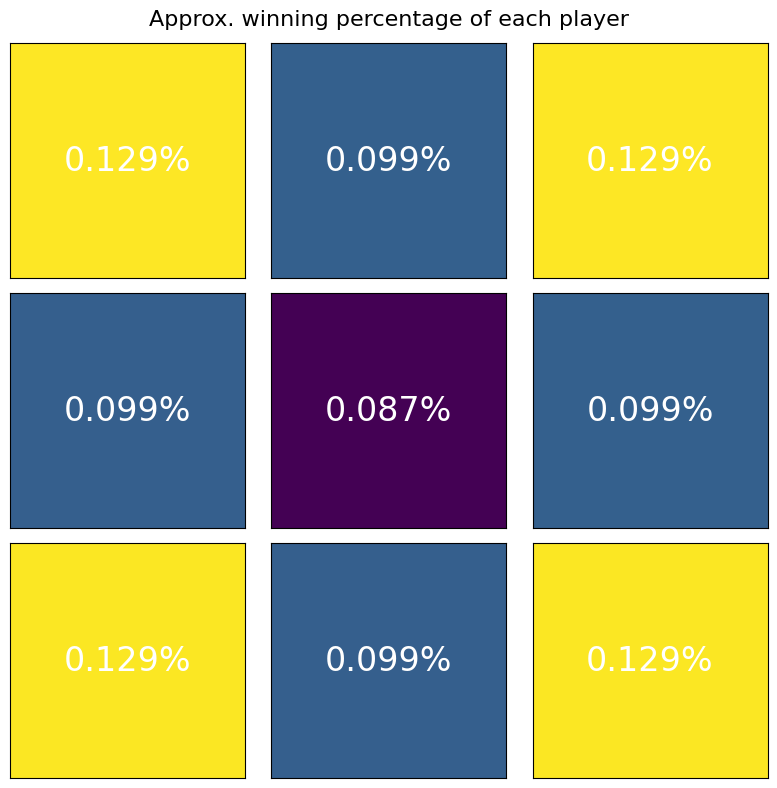

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

percentages = [perc for (_, perc) in sorted(stats)]

norm = mcolors.Normalize(vmin=min(percentages), vmax=max(percentages))

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Approx. winning percentage of each player', fontsize=16)

for i, ax in enumerate(axes.flat):
    color = plt.cm.viridis(norm(percentages[i]))
    ax.set_facecolor(color)
    ax.text(0.5, 0.5, f'{round(percentages[i], 3)}%', fontsize=24, ha='center', va='center', color='white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

So, opt for a corner square. This will reduce the likelihood of confrontations with other players and thereby help preserve your territory.

## Next

My time is up.

Given more time, I'd:

- try to compute confidence intervals for the probabilities of winning for each position. That would allow making the above experiment more reliable and also possibly reduce the number of simulations needed.

- Work out the underlying distribution (this is best done in part 2 I guess). In these problems, often, `maths > coding`, this would yield the *exact* probabilities of winning for each position without the need for simulations. I would perhaps start defining the sequential relationship between time_t and time_t+1, and then try to find a pattern in the distribution of the number of squares each player has at time_t+1 given the number of squares they had at time_t. This would be a good starting point to understand the problem better.